In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re


In [227]:
df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_960/2776905057.py:1: DtypeWarning: Columns (359,360,363,364,613,614,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")


In [228]:
df.head()

,caseid,tookpost,commonweight,commonpostweight,CCEStake,add_confirm,inputzip,birthyr,gender4,gender4_t,...,page_CC22_441_grid_timing,page_CC22_443_timing,page_gunown_timing,page_numchildren_timing,page_edloan_timing,page_student_timing,starttime,endtime,starttime_post,endtime_post
0,1983126005,2,3.649671,3.525008,1,1.0,NaN,1992,1,__NA__,...,12.128,12.506,6.337,6.265,2.863,0.0,1.980030e+12,1.980030e+12,1.985230e+12,1.985230e+12
1,1983126559,2,0.780431,0.818539,1,NaN,1331.0,1957,1,__NA__,...,18.707,21.805,3.126,9.023,3.722,0.0,1.980030e+12,1.980030e+12,1.986030e+12,1.986030e+12
2,1983126197,2,0.891555,0.774314,1,1.0,NaN,1978,2,__NA__,...,6.448,4.443,2.105,3.108,3.622,0.0,1.980030e+12,1.980030e+12,1.984610e+12,1.984610e+12
3,1979974411,2,1.103598,1.207156,1,NaN,6716.0,1991,3,__NA__,...,11.287,10.843,5.421,4.947,3.000,0.0,1.980030e+12,1.980030e+12,1.984480e+12,1.984490e+12
4,1983130427,2,0.542923,0.327550,1,2.0,21401.0,1991,1,__NA__,...,12.222,19.317,3.458,3.843,4.173,0.0,1.980030e+12,1.980030e+12,1.985620e+12,1.985620e+12


In [229]:
# Create a new dataframe with 'caseid', 'voted', and 'senate_vote_choice' columns
new_df = df[['caseid']].copy()

# Create the 'voted' variable
new_df['voted'] = (df['CC22_401'] == 5).astype(int)

def get_senate_vote_choice(row):
    pre_vote = row['CC22_365_voted']
    post_vote = row['CC22_411']
    pre_state = row['inputstate']
    post_state = row['inputstate_post']

    def get_candidate_info(vote, suffix=''):
        if 1 <= vote <= 4:
            return row[f'SenCand{int(vote)}Name{suffix}'], row[f'SenCand{int(vote)}Party{suffix}']
        else:
            return None, None

    if pd.notna(pre_vote) and pd.notna(post_vote):
        if pre_vote == post_vote:
            name, party = get_candidate_info(post_vote, '_post')
            return post_vote, name, party, post_state
        else:
            return float('nan'), None, None, None  # set as missing if contradictory responses
    elif pd.notna(pre_vote):
        name, party = get_candidate_info(pre_vote)
        return pre_vote, name, party, pre_state
    elif pd.notna(post_vote):
        name, party = get_candidate_info(post_vote, '_post')
        return post_vote, name, party, post_state
    else:
        return float('nan'), None, None, None  # set as missing if both are missing

# Apply the updated function to the dataframe
new_df[['senate_vote_choice', 'senator_name', 'party', 'state']] = df.apply(get_senate_vote_choice, axis=1, result_type='expand')

#if voted for republican senator, party_voted is 0, if voted for democrats, party_voted is 1. Otherwise the value is -1
new_df['party_voted'] = new_df['party'].apply(lambda party: 1 if party == 'Democratic' else (0 if party == 'Republican' else (-1 if pd.isna(party) else 2)))
new_df = new_df.drop(columns=['party'])

new_df.head()


,caseid,voted,senate_vote_choice,senator_name,state,party_voted
0,1983126005,1,NaN,NaN,NaN,-1
1,1983126559,1,NaN,NaN,NaN,-1
2,1983126197,1,1.0,John Fetterman,42.0,1
3,1979974411,1,1.0,Richard Blumenthal,9.0,1
4,1983130427,0,NaN,NaN,NaN,-1


In [230]:
# Add the specified columns from 'df' to 'new_df'
control_vr = [ 'commonweight', 'commonpostweight','birthyr', 'gender4', 'educ', 'race', 'faminc_new', 'marstat', 'urbancity', 'region', 'presvote20post', 'presvote16post', \
    'pew_bornagain', 'pew_religimp', 'pew_churatd', 'pew_prayer', 'religpew', 'ideo5', 'CC22_320a', 'CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party',\
    'CC22_430a_8', 'CC22_310b', 'CC22_303', 'CC22_304']
important_vr = ['CC22_360', 'pid3', 'pid7', 'CC22_332a', 'CC22_332b', 'CC22_332c', 'CC22_332d', 'CC22_332e', 'CC22_332f', 'CC22_350d']
new_df = pd.concat([new_df, df[control_vr]], axis=1)
new_df = pd.concat([new_df, df[important_vr]], axis=1)

In [231]:
# Cleaning columns
new_df['age'] = 2022 - df['birthyr']
new_df = new_df.drop('birthyr', axis=1)

In [232]:
#if there is political involvement, give vaue 1, else 0
new_df['pol_involve'] = new_df['CC22_430a_8'].apply(lambda x: 0 if x > 6 else 1)
new_df = new_df.drop(columns=['CC22_430a_8'])

#Calculate approval for senators in different political parties
recode_map = {1: 2, 2: 1, 5: 0, 3: -1, 4: -2}
new_df['CC22_320g'] = new_df['CC22_320g'].map(recode_map)
df['CC22_320h'] = df['CC22_320h'].map(recode_map)

# Define a function to calculate the average rating for a given party
def get_party_attitude(row, party):
    ratings = []
    if row['CurrentSen1Party'] == party:
        ratings.append(row['CC22_320g'])
    if row['CurrentSen2Party'] == party:
        ratings.append(row['CC22_320h'])
    
    return sum(ratings) / len(ratings) if ratings else None

# Create new columns 'attitude_towards_party' as the average rating for each party
new_df['attitude_towards_dem'] = new_df.apply(lambda row: get_party_attitude(row, 'Democratic'), axis=1)
new_df['attitude_towards_rep'] = new_df.apply(lambda row: get_party_attitude(row, 'Republican'), axis=1)

# Drop the original columns
new_df = new_df.drop(columns=['CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party'])

In [233]:
column_mapping = {'senator_name': 'senator_voted', 'gender4':'gender', 'faminc_new': 'fam_income',\
    'ideo5': 'pol_ideo', 'CC22_320a': 'approval_biden', 'CC22_310b': 'know_senate', 'CC22_303': 'income_change', 'CC22_304': 'price_change',\
    'CC22_360': 'party_registered', 'pid3': 'party_identified', 'pid7': 'party_strength', 'CC22_332a':'abortion_all_cases', 'CC22_332b':'abortion_some_cases', \
    'CC22_332c': 'abortion_before_20weeks', 'CC22_332d': 'abortion_coverage', 'CC22_332e': 'abortion_funds', 'CC22_332f': 'abortion_illegal', 'CC22_350d': 'congress_abortion'}

new_df = new_df.rename(columns=column_mapping)

#cast column type
nonint_col = ['senator_voted', 'party_voted', 'commonweight', 'commonpostweight', 'attitude_towards_dem', 'attitude_towards_rep']
for i in new_df.columns.to_list():
    if i not in nonint_col:
        new_df[i].fillna(-1, inplace=True)
        new_df[i] = new_df[i].astype(int)

In [234]:
#create column for states with abortion on ballot
abortion_states = [6, 21, 26, 30, 50]
new_df['abortion_ballot'] = new_df['state'].apply(lambda row: 1 if row in abortion_states else 0)

In [235]:
new_df

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_before_20weeks,abortion_coverage,abortion_funds,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot
0,1983126005,1,-1,NaN,-1,-1,3.649671,3.525008,1,6,...,2,2,2,2,1,30,1,1.5,NaN,0
1,1983126559,1,-1,NaN,-1,-1,0.780431,0.818539,1,3,...,2,2,1,2,1,65,1,1.0,NaN,0
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,2,2,2,1,44,1,0.0,5.0,0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,2,2,2,1,31,1,1.0,NaN,0
4,1983130427,0,-1,NaN,-1,-1,0.542923,0.327550,1,6,...,1,2,2,2,1,31,1,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2045974583,0,-1,NaN,-1,-1,0.255190,NaN,2,2,...,2,1,2,2,2,37,1,NaN,2.5,0
59996,2045981019,0,-1,NaN,-1,-1,1.478491,0.930118,2,4,...,2,2,2,2,1,26,1,NaN,2.5,0
59997,2045852523,0,-1,NaN,-1,-1,0.195928,NaN,1,2,...,2,2,2,2,2,33,1,1.0,2.0,0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,1,1,1,2,1,32,1,1.5,NaN,0


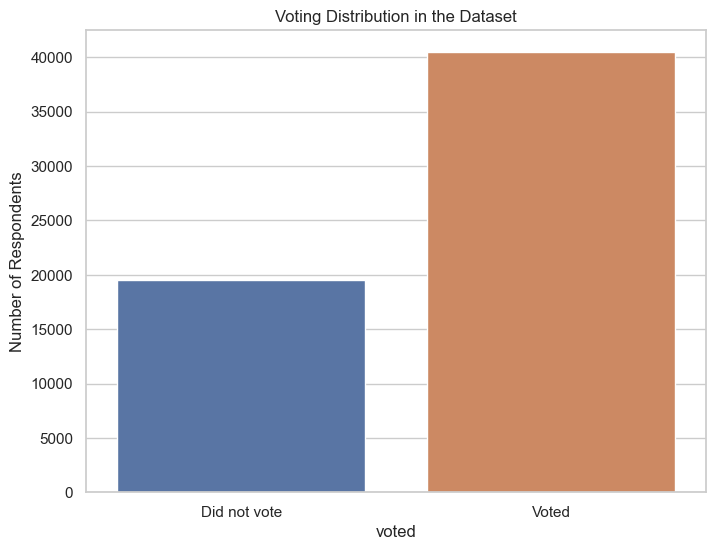

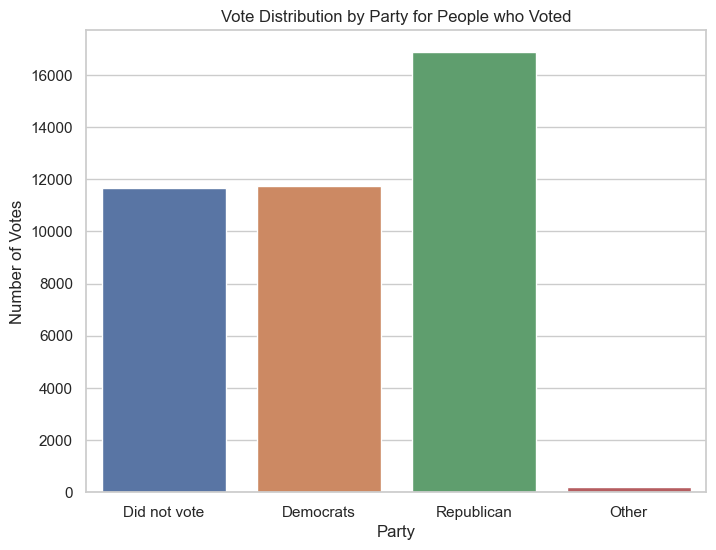

In [236]:
# Set the style for the plots
sns.set(style='whitegrid')

# Plot the distribution of how many people voted in the dataset
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df, x='voted')
ax.set_xticklabels(['Did not vote', 'Voted'])
ax.set_title('Voting Distribution in the Dataset')
ax.set_ylabel('Number of Respondents')
plt.show()

# Plot the distribution of people who voted for each party
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df[new_df['voted'] == 1], x='party_voted')
ax.set_xticklabels(['Did not vote', 'Democrats', 'Republican', 'Other'])
ax.set_title('Vote Distribution by Party for People who Voted')
ax.set_xlabel('Party')
ax.set_ylabel('Number of Votes')
plt.show()


In [238]:
# Function to extract the social and economic scores from the website
def extract_scores(candidate_website):
    # Request the candidate's website
    response = requests.get(candidate_website)
    
    # Parse the website's HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the "Click for details" hyperlink
    details_link = soup.find('a', href=re.compile(r'^https://www.OnTheIssues.org/VoteMatch/candidate_map.asp'))
    
    if details_link is None:
        return -1, -1
    
    # Follow the "Click for details" hyperlink
    url = details_link['href']
    response = requests.get(url)

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the social and economic scores in the HTML
    all_tr = soup.find_all("tr")

    # Extract the social and economic scores
    social_score = all_tr[5].find_all("td")[1].find("font").text.strip("%")
    economic_score = all_tr[6].find_all("td")[1].find("font").text.strip("%")

    return social_score, economic_score

#function that stores the scores in the dataframe
def store_scores(df):
    for i, row in df.iterrows():
        name = row['senator']
        if name == 'J.D. Vance':
            str = 'JD_Vance'
        elif name == 'Thomas McDermott Jr.':
            str = 'Thomas_McDermott'
        elif name == 'Todd C. Young':
            str = 'Todd_Young'
        elif name == "Joe O'Dea":
            str = 'Joe_O%60Dea'
        elif name == 'John Kennedy':
            str = 'John_Neely_Kennedy'
        elif name == 'Mark R. Holland':
            str = 'Mark_Holland'
        else:
            str = "_".join(name.split())
        
        url = "https://www.ontheissues.org/Senate/" + str + '.htm' 
        social_score, economic_score = extract_scores(url)
        df.at[i, 'social_score'] = social_score
        df.at[i, 'economic_score'] = economic_score

In [239]:
#create a dataframe to store candidate information
candidate_df = new_df[['senator_voted', 'state', 'party_voted']].groupby('senator_voted').first().reset_index()
candidate_df.columns = ['senator', 'state', 'party']

#import candidates endorsed by trump
trump_endorsement = pd.read_csv('trump_endorsement.csv', skiprows=1, header=None)
trump_endorsement.columns = ['endorsed_senator']

#create new column about trump endorsement
candidate_df['trump_endorsement'] = candidate_df['senator'].isin(trump_endorsement['endorsed_senator']).astype(int)

#create new columns the store the scores of each candidate
store_scores(candidate_df)

In [240]:
candidate_df

,senator,state,party,trump_endorsement,social_score,economic_score
0,Adam Laxalt,32,0,1,28,83
1,Alex Padilla,6,1,0,83,25
2,Blake Masters,4,0,1,25,80
3,Bob McDermott,15,0,0,30,63
4,Brian Bengs,46,1,0,43,30
...,...,...,...,...,...,...
69,Todd C. Young,18,0,0,35,85
70,Tommy Williams,49,2,0,-1,-1
71,Trudy Busch Valentine,29,1,0,53,15
72,Val Demings,12,1,0,83,15


In [241]:
# Select only the required columns for aggregation
agg_columns = candidate_df[['state', 'party', 'social_score', 'economic_score', 'trump_endorsement']]

# Convert 'social_score' and 'economic_score' to numeric data types
candidate_df['social_score'] = pd.to_numeric(candidate_df['social_score'], errors='coerce')
candidate_df['economic_score'] = pd.to_numeric(candidate_df['economic_score'], errors='coerce')

# Group by 'state' and 'party' and calculate the mean 'social_score', 'economic_score', and 'trump_endorsement' for each group
state_level_agg = candidate_df.groupby(['state', 'party']).agg({
    'social_score': 'mean',
    'economic_score': 'mean',
    'trump_endorsement': lambda x: x.astype(int).mean()
}).reset_index()

# Merge
merged_df = new_df.merge(state_level_agg, how='left', left_on=['state', 'party_voted'], right_on=['state', 'party'])

# Drop the 'party' column since it is not needed anymore
merged_df.drop('party', axis=1, inplace=True)

# Display the updated dataframe
merged_df


,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot,social_score,economic_score,trump_endorsement
0,1983126005,1,-1,NaN,-1,-1,3.649671,3.525008,1,6,...,2,1,30,1,1.5,NaN,0,NaN,NaN,NaN
1,1983126559,1,-1,NaN,-1,-1,0.780431,0.818539,1,3,...,2,1,65,1,1.0,NaN,0,NaN,NaN,NaN
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,1,44,1,0.0,5.0,0,80.0,25.0,0.0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,1,31,1,1.0,NaN,0,65.0,15.0,0.0
4,1983130427,0,-1,NaN,-1,-1,0.542923,0.327550,1,6,...,2,1,31,1,1.0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2045974583,0,-1,NaN,-1,-1,0.255190,NaN,2,2,...,2,2,37,1,NaN,2.5,0,NaN,NaN,NaN
59996,2045981019,0,-1,NaN,-1,-1,1.478491,0.930118,2,4,...,2,1,26,1,NaN,2.5,0,NaN,NaN,NaN
59997,2045852523,0,-1,NaN,-1,-1,0.195928,NaN,1,2,...,2,2,33,1,1.0,2.0,0,NaN,NaN,NaN
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,2,1,32,1,1.5,NaN,0,70.0,5.0,0.0


In [243]:
merged_df = merged_df[(merged_df['voted'] != 0) & (merged_df['senate_vote_choice'] != -1)]
merged_df

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot,social_score,economic_score,trump_endorsement
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,1,44,1,0.0,5.0,0,80.0,25.0,0.0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,1,31,1,1.0,NaN,0,65.0,15.0,0.0
5,1981687607,1,2,Don Bolduc,33,0,0.114487,0.098909,1,5,...,2,2,67,1,1.0,NaN,0,33.0,73.0,1.0
6,1983125989,1,1,Raphael Warnock,13,1,0.899045,1.210827,2,2,...,2,2,54,1,0.5,NaN,0,68.0,15.0,0.0
8,1981900613,1,1,John Fetterman,42,1,0.900071,0.853897,2,5,...,2,1,75,1,-1.0,3.0,0,80.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,2046109403,1,2,Ted Budd,37,0,1.504072,1.469039,2,2,...,1,1,29,1,NaN,2.5,0,20.0,90.0,1.0
59991,2046109215,1,1,Alex Padilla,6,1,1.058854,0.826751,2,6,...,1,1,35,1,2.0,NaN,1,83.0,25.0,0.0
59993,2046149923,1,1,Chuck Schumer,36,1,0.949129,0.814437,2,6,...,2,1,31,1,3.0,NaN,0,70.0,5.0,0.0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,2,1,32,1,1.5,NaN,0,70.0,5.0,0.0
